In [6]:
#https://github.com/Gurobi/gurobi-machinelearning/blob/main/notebooks/adversarial/adversarial_keras.ipynb
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

import gurobipy as gp


from gurobi_ml import add_predictor_constr

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [9]:
x_train = tf.reshape(tf.cast(x_train, tf.float32) / 255.0, [-1, 28 * 28])
x_test = tf.reshape(tf.cast(x_test, tf.float32) / 255.0, [-1, 28 * 28])

In [12]:
nn = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer((28 * 28,)),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(10),
    ]
)

In [14]:
nn.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [17]:
nn.fit(
    x_train,
    y_train,
    epochs=6,
    validation_data=(x_test, y_test),
)

Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 0.0470 - sparse_categorical_accuracy: 0.9841 - val_loss: 0.1133 - val_sparse_categorical_accuracy: 0.9658
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9876 - val_loss: 0.1028 - val_sparse_categorical_accuracy: 0.9730
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - loss: 0.0342 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.1175 - val_sparse_categorical_accuracy: 0.9699
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0314 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.1256 - val_sparse_categorical_accuracy: 0.9658
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0296 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.1238 - val_sparse_categorical_accuracy: 0.9686
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9924 - val_loss: 0.1099 - val_sparse_categorical_acc

In [18]:
nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │          39,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,932 (495.83 KB)

 Trainable params: 42,310 (165.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 84,622 (330.56 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Example is classified as [6]


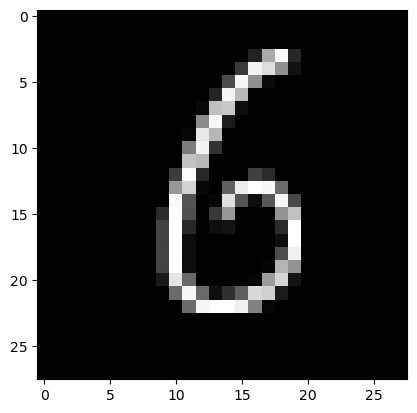

In [21]:
example = x_train[18, :]
plt.imshow(tf.reshape(example, [28, 28]), cmap="gray")
label = tf.math.argmax(nn.predict(tf.reshape(example, (1, -1))), axis=1)
print(f"Example is classified as {label}")

In [22]:
ex_prob = nn.predict(tf.reshape(example, (1, -1)))
sorted_labels = tf.argsort(ex_prob)[0]
right_label = sorted_labels[-1]
wrong_label = sorted_labels[-2]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


In [25]:
m = gp.Model()
delta = 5

x = m.addMVar(example.numpy().shape, lb=0.0, ub=1.0, name="x")
y = m.addMVar(ex_prob.shape, lb=-gp.GRB.INFINITY, name="y")

abs_diff = m.addMVar(example.numpy().shape, lb=0, ub=1, name="abs_diff")

m.setObjective(y[0, wrong_label] - y[0, right_label], gp.GRB.MAXIMIZE)

# Bound on the distance to example in norm-1
m.addConstr(abs_diff >= x - example.numpy())
m.addConstr(abs_diff >= -x + example.numpy())
m.addConstr(abs_diff.sum() <= delta)

pred_constr = add_predictor_constr(m, nn, x, y)

pred_constr.print_stats()

Restricted license - for non-production use only - expires 2026-11-23
Model for sequential:
200 variables
110 constraints
100 general constraints
Input has shape (1, 784)
Output has shape (1, 10)

--------------------------------------------------------------------------------
Layer           Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
dense0               (1, 50)          100           50            0           50 (relu)

dense1               (1, 50)          100           50            0           50 (relu)

dense2               (1, 10)            0           10            0            0

--------------------------------------------------------------------------------


In [27]:
m.Params.BestBdStop = 0.0
m.Params.BestObjStop = 0.0
m.optimize()

Set parameter BestBdStop to value 0
Set parameter BestObjStop to value 0
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22000.2))

CPU model: Intel(R) Core(TM) i5-5300U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
BestObjStop  0
BestBdStop  0

Optimize a model with 1679 rows, 1778 columns and 46230 nonzeros
Model fingerprint: 0x6a559054
Model has 100 simple general constraints
  100 MAX
Variable types: 1778 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [8e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 5e+00]
Presolve removed 1214 rows and 636 columns
Presolve time: 3.00s
Presolved: 465 rows, 1142 columns, 43388 nonzeros
Variable types: 1066 continuous, 76 integer (76 binary)

Root relaxation: objective 1.696381e+03, 303 iterations, 0.07 seconds (0.01 work units)

    Node

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Solution is classified as [8]


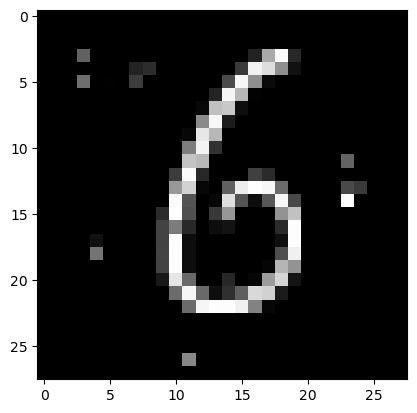

In [28]:
if m.ObjVal > 0.0:
    plt.imshow(x.X.reshape((28, 28)), cmap="gray")
    label = tf.math.argmax(nn.predict(tf.reshape(x.X, (1, -1))), axis=1)
    print(f"Solution is classified as {label}")
else:
    print("No counter example exists in neighborhood.")